comparing FYI/MYI CS2_CPOM and SM-LG smoothed anomalies for 2010-2020 seasons 1 Dec - 30 Apr

In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import seaborn as sns
from matplotlib import gridspec
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load all prep 

# 1 Oct - 30 Apr
seasonal_days = [np.arange(273,484), # 2010-2011
        np.arange(638,850), # 2011-2012
        np.arange(1004,1215), # 2012-2013
        np.arange(1369,1580), # 2013-2014
        np.arange(1734,1945), # 2014-2015
        np.arange(2099,2311), # 2015-2016
        np.arange(2464,2676), # 2016-2017
        np.arange(2830,3041), # 2017-2018
        np.arange(3194,3406), # 2018-2019
        np.arange(3560,3772) # 2019-2020
       ]

# 1 Dec - 1 Apr
# seasonal_days = [np.arange(334,455), # 2010-2011
#         np.arange(699,821), # 2011-2012
#         np.arange(1065,1186), # 2012-2013
#         np.arange(1430,1551), # 2013-2014
#         np.arange(1795,1916), # 2014-2015
#         np.arange(2160,2282), # 2015-2016
#         np.arange(2526,2647), # 2016-2017
#         np.arange(2891,3012), # 2017-2018
#         np.arange(3256,3377), # 2018-2019
#         np.arange(3621,3743) # 2019-2020
#        ]

seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020']

days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') # load Will's grid, 160 x 160 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')

snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/SM_snod_combined_regridded.npy')

# import CS2_CPOM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_CPOM/'
all_fbs_cpom = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs_cpom[day] = np.load(datapath+str(f))
            else: 
                pass

# import CS2_LARM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/Bristol_LARM/CS2/freeboard/'
all_fbs_larm = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs_larm[day] = np.load(datapath+str(f))
            else: 
                pass

# import CS2S3_CPOM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_S3_GPOD/MERGE/'
all_fbs_s3_cpom = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs_s3_cpom[day] = np.load(datapath+str(f))
            else: 
                pass
            
# import CS2S3_LARM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/GPOD_Bristol/MERGE/'
all_fbs_s3_larm = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs_s3_larm[day] = np.load(datapath+str(f))
            else: 
                pass

100%|█████████████████████████████████████| 4018/4018 [00:01<00:00, 2141.32it/s]


In [3]:
# function to calculate running mean, where T = np.int(number of days/2)

def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T+1]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T+1]))

    for i in range(np.size(means)-T,np.size(means)+1):
        r.append(np.nanmean(means[i-T:]))

    return r

In [4]:
CPOM_FYI = {}
CPOM_MYI = {}
cpom_ps = np.full((10,2),np.nan)
LARM_FYI = {}
LARM_MYI = {}
larm_ps = np.full((10,2),np.nan)
counters_y = np.arange(0,10)

fyis = [CPOM_FYI,LARM_FYI]
myis = [CPOM_MYI,LARM_MYI]
ps = [cpom_ps,larm_ps]
fbs = [all_fbs_cpom,all_fbs_larm]


for fyi,myi,pss,f in zip(fyis,myis,ps,fbs):

    for season, days, counter in zip(seasons,seasonal_days, counters_y):
        dayss = np.arange(0,len(days))
        fb = f[days]
        sm = snow[days]

        icetype_grid = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')

        #get grid cells which have been either FYI or MYI for the whole season
        FYI_row = [] ; MYI_row = []
        FYI_col = [] ; MYI_col = []
        for i in range(160):
            for j in range(160):
                if (icetype_grid[i,j,:] == 2).all():
                    FYI_row.append(i) ; FYI_col.append(j)
                elif (icetype_grid[i,j,:] == 3).all():
                    MYI_row.append(i) ; MYI_col.append(j)                
        FYI = (FYI_row,FYI_col)
        MYI = (MYI_row,MYI_col)

        zones = [FYI,MYI]

        snow_FYI = np.full((len(dayss),160,160),np.nan)
        snow_MYI = np.full((len(dayss),160,160),np.nan)
        snow_mean_FYI = np.full(len(dayss),np.nan)
        snow_mean_MYI = np.full(len(dayss),np.nan)


        fb_FYI = np.full((len(dayss),160,160),np.nan)
        fb_MYI = np.full((len(dayss),160,160),np.nan)
        fb_mean_FYI = np.full(len(dayss),np.nan)
        fb_mean_MYI = np.full(len(dayss),np.nan)

        for day in dayss:
            snowz=sm[day]
            fbz = fb[day]

            #FYI
            a = snowz[FYI]
            snow_mean_FYI[day] = np.nanmean(a) * 100
            b = fbz[FYI]
            fb_mean_FYI[day] = np.nanmean(b) * 100

            #MYI
            a = snowz[MYI]
            snow_mean_MYI[day] = np.nanmean(a) * 100
            b = fbz[MYI]
            fb_mean_MYI[day] = np.nanmean(b) * 100

        snow_mean_FYI_smooth = runningmean(snow_mean_FYI,T=15)
        snow_mean_FYI_anom = runningmean(np.asarray(snow_mean_FYI) - np.asarray(snow_mean_FYI_smooth[:-1]), T=4)
        fb_mean_FYI_smooth = runningmean(fb_mean_FYI,T=15)
        fb_mean_FYI_anom = runningmean(np.asarray(fb_mean_FYI) - np.asarray(fb_mean_FYI_smooth[:-1]), T=4)

        snow_mean_MYI_smooth = runningmean(snow_mean_MYI,T=15)
        snow_mean_MYI_anom = runningmean(np.asarray(snow_mean_MYI) - np.asarray(snow_mean_MYI_smooth[:-1]), T=4)
        fb_mean_MYI_smooth = runningmean(fb_mean_MYI,T=15)
        fb_mean_MYI_anom = runningmean(np.asarray(fb_mean_MYI) - np.asarray(fb_mean_MYI_smooth[:-1]), T=4)

        # uncomment to look at only positive snow anoms
        # snow_mean_FYI_anom = np.asarray(snow_mean_FYI_anom)
        # snow_mean_FYI_anom[snow_mean_FYI_anom<0]=np.nan
        # snow_mean_MYI_anom = np.asarray(snow_mean_MYI_anom)
        # snow_mean_MYI_anom[snow_mean_MYI_anom<0]=np.nan

        snows = np.asarray(snow_mean_FYI_anom)
        freebs = np.asarray(fb_mean_FYI_anom)
        mask = ~np.isnan(snows) & ~np.isnan(freebs)
        rstats = pearsonr(snows[mask],freebs[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)

        fyi[season] = r
        pss[counter,0] = p

        snows = np.asarray(snow_mean_MYI_anom)
        freebs = np.asarray(fb_mean_MYI_anom)
        mask = ~np.isnan(snows) & ~np.isnan(freebs)

        rstats = pearsonr(snows[mask],freebs[mask])
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)

        myi[season] = r
        pss[counter,1] = p

In [5]:
CPOM_S3_FYI = {}
CPOM_S3_MYI = {}
cpom_s3_ps = np.full((1,2),np.nan)
LARM_S3_FYI = {}
LARM_S3_MYI = {}
larm_s3_ps = np.full((1,2),np.nan)
# counters_y = np.arange(0,10)

fyis = [CPOM_S3_FYI,LARM_S3_FYI]
myis = [CPOM_S3_MYI,LARM_S3_MYI]
ps = [cpom_s3_ps,larm_s3_ps]
fbs = [all_fbs_s3_cpom,all_fbs_s3_larm]

days = seasonal_days[9]
season = '2019-2020'

for fyi,myi,pss,f in zip(fyis,myis,ps,fbs):
    dayss = np.arange(0,len(days))
    fb = f[days]
    sm = snow[days]

    icetype_grid = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/icetype/icetype_Oct'+season.split('-')[0]+'_Apr'+season.split('-')[1]+'_'+season+'.npy')

    #get grid cells which have been either FYI or MYI for the whole season
    FYI_row = [] ; MYI_row = []
    FYI_col = [] ; MYI_col = []
    for i in range(160):
        for j in range(160):
            if (icetype_grid[i,j,:] == 2).all():
                FYI_row.append(i) ; FYI_col.append(j)
            elif (icetype_grid[i,j,:] == 3).all():
                MYI_row.append(i) ; MYI_col.append(j)                
    FYI = (FYI_row,FYI_col)
    MYI = (MYI_row,MYI_col)

    zones = [FYI,MYI]

    snow_FYI = np.full((len(dayss),160,160),np.nan)
    snow_MYI = np.full((len(dayss),160,160),np.nan)
    snow_mean_FYI = np.full(len(dayss),np.nan)
    snow_mean_MYI = np.full(len(dayss),np.nan)


    fb_FYI = np.full((len(dayss),160,160),np.nan)
    fb_MYI = np.full((len(dayss),160,160),np.nan)
    fb_mean_FYI = np.full(len(dayss),np.nan)
    fb_mean_MYI = np.full(len(dayss),np.nan)

    for day in dayss:
        snowz=sm[day]
        fbz = fb[day]

        #FYI
        a = snowz[FYI]
        snow_mean_FYI[day] = np.nanmean(a) * 100
        b = fbz[FYI]
        fb_mean_FYI[day] = np.nanmean(b) * 100

        #MYI
        a = snowz[MYI]
        snow_mean_MYI[day] = np.nanmean(a) * 100
        b = fbz[MYI]
        fb_mean_MYI[day] = np.nanmean(b) * 100

    snow_mean_FYI_smooth = runningmean(snow_mean_FYI,T=15)
    snow_mean_FYI_anom = runningmean(np.asarray(snow_mean_FYI) - np.asarray(snow_mean_FYI_smooth[:-1]), T=4)
    fb_mean_FYI_smooth = runningmean(fb_mean_FYI,T=15)
    fb_mean_FYI_anom = runningmean(np.asarray(fb_mean_FYI) - np.asarray(fb_mean_FYI_smooth[:-1]), T=4)

    snow_mean_MYI_smooth = runningmean(snow_mean_MYI,T=15)
    snow_mean_MYI_anom = runningmean(np.asarray(snow_mean_MYI) - np.asarray(snow_mean_MYI_smooth[:-1]), T=4)
    fb_mean_MYI_smooth = runningmean(fb_mean_MYI,T=15)
    fb_mean_MYI_anom = runningmean(np.asarray(fb_mean_MYI) - np.asarray(fb_mean_MYI_smooth[:-1]), T=4)

    # uncomment to look at only positive snow anoms
    # snow_mean_FYI_anom = np.asarray(snow_mean_FYI_anom)
    # snow_mean_FYI_anom[snow_mean_FYI_anom<0]=np.nan
    # snow_mean_MYI_anom = np.asarray(snow_mean_MYI_anom)
    # snow_mean_MYI_anom[snow_mean_MYI_anom<0]=np.nan

    snows = np.asarray(snow_mean_FYI_anom)
    freebs = np.asarray(fb_mean_FYI_anom)
    mask = ~np.isnan(snows) & ~np.isnan(freebs)
    rstats = pearsonr(snows[mask],freebs[mask])
    r = np.round(rstats[0],decimals=2)
    p = np.round(rstats[1],decimals=3)

    fyi[season] = r
    pss[0,0] = p

    snows = np.asarray(snow_mean_MYI_anom)
    freebs = np.asarray(fb_mean_MYI_anom)
    mask = ~np.isnan(snows) & ~np.isnan(freebs)

    rstats = pearsonr(snows[mask],freebs[mask])
    r = np.round(rstats[0],decimals=2)
    p = np.round(rstats[1],decimals=3)

    myi[season] = r
    pss[0,1] = p

In [6]:
df_FYI_CPOM = pd.DataFrame.from_dict(CPOM_FYI, columns=[' '], orient = 'index')
df_MYI_CPOM = pd.DataFrame.from_dict(CPOM_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_CPOM,df_MYI_CPOM] 

df_combined_CPOM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)


df_FYI_LARM = pd.DataFrame.from_dict(LARM_FYI, columns=[' '], orient = 'index')
df_MYI_LARM = pd.DataFrame.from_dict(LARM_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_LARM,df_MYI_LARM] 

df_combined_LARM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)

df_FYI_S3_CPOM = pd.DataFrame.from_dict(CPOM_S3_FYI, columns=[' '], orient = 'index')
df_MYI_S3_CPOM = pd.DataFrame.from_dict(CPOM_S3_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_S3_CPOM,df_MYI_S3_CPOM] 

df_combined_S3_CPOM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)

df_FYI_S3_LARM = pd.DataFrame.from_dict(LARM_S3_FYI, columns=[' '], orient = 'index')
df_MYI_S3_LARM = pd.DataFrame.from_dict(LARM_S3_MYI, columns=[' '], orient = 'index')

sets = [df_FYI_S3_LARM,df_MYI_S3_LARM] 

df_combined_S3_LARM = pd.concat(
    [df.rename(columns=lambda x: x.zfill(0)) for df in sets],
    keys=['FYI', 'MYI'],
    axis=1)

In [7]:
print(df_combined_CPOM)
print(df_combined_LARM)
print(df_combined_S3_CPOM)
print(df_combined_S3_LARM)

            FYI   MYI
                     
2010-2011 -0.12 -0.12
2011-2012 -0.27 -0.17
2012-2013  0.24 -0.01
2013-2014  0.16 -0.01
2014-2015  0.01  0.12
2015-2016 -0.15  0.22
2016-2017 -0.14  0.28
2017-2018  0.46 -0.06
2018-2019 -0.21  0.34
2019-2020  0.54 -0.26
            FYI   MYI
                     
2010-2011  0.23  0.33
2011-2012 -0.01 -0.55
2012-2013  0.35 -0.11
2013-2014  0.23  0.00
2014-2015  0.00  0.34
2015-2016  0.23 -0.15
2016-2017 -0.27  0.48
2017-2018  0.20  0.40
2018-2019 -0.03  0.57
2019-2020  0.35 -0.22
            FYI   MYI
                     
2019-2020  0.49 -0.31
            FYI   MYI
                     
2019-2020  0.56 -0.08


In [8]:
%%capture output
x = plt.imshow(np.full((3,3),np.nan),vmin=-1,vmax=1,cmap='RdBu')

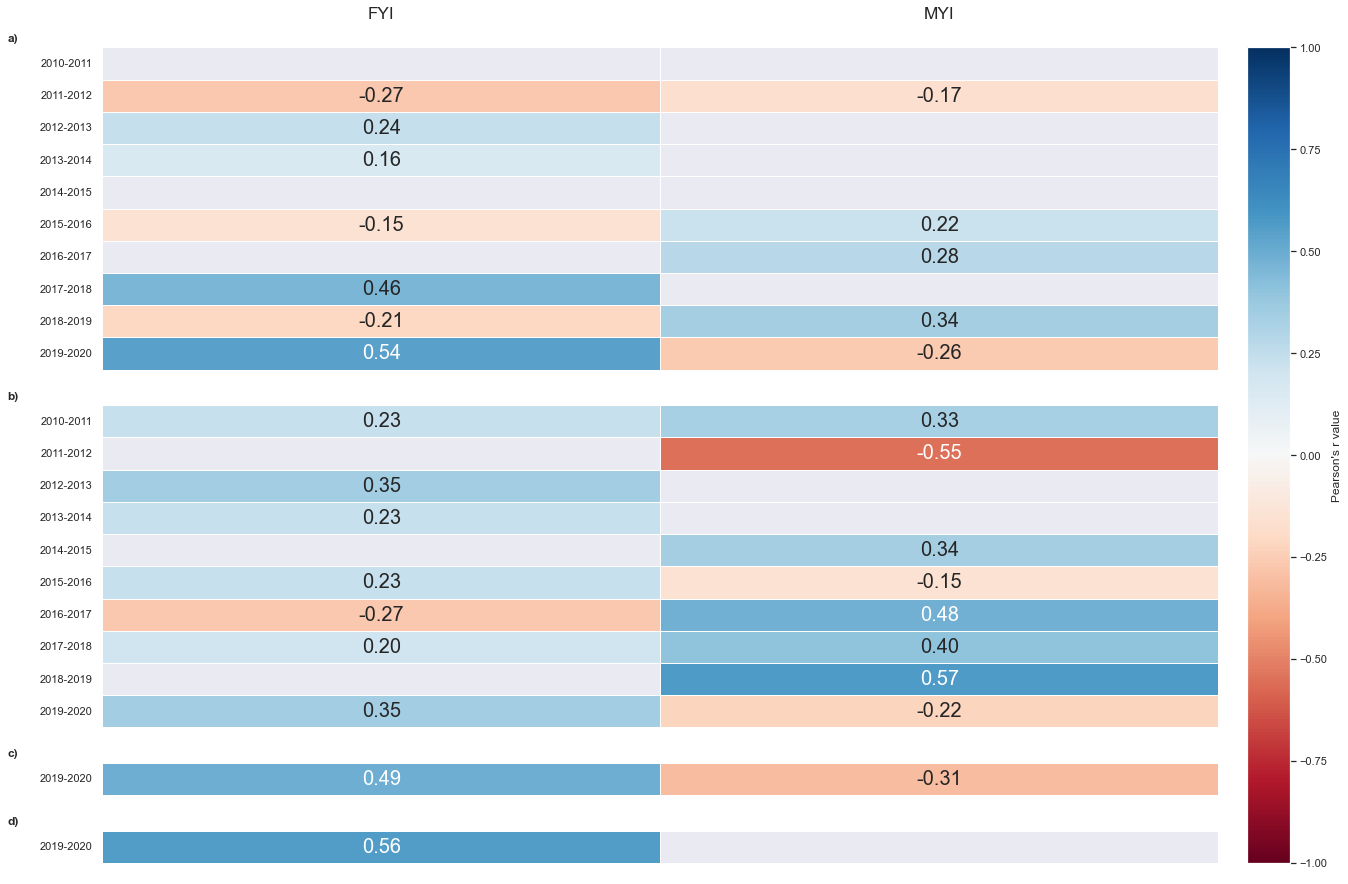

In [21]:
seasons = ['2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017','2017-2018','2018-2019',
          '2019-2020']
keys = ['FYI', 'MYI']
fig = plt.figure(figsize = (20,15))
spec = gridspec.GridSpec(ncols=1, nrows=4,
                         width_ratios=[1], wspace=0.5,
                         hspace=0.2, height_ratios=[10,10,1,1])


# CS2_CPOM
ax1 = fig.add_subplot(spec[0])
mask = cpom_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax1 = sns.heatmap(df_combined_CPOM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax1.xaxis.tick_top()
ax1.set_xlabel(' ')    
ax1.set_yticklabels(seasons,rotation = 0)
ax1.set_xticklabels(keys,fontsize='x-large',y=1.05)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=True)
ax1.set_title('a)', x = -0.08,y = 1,fontweight="bold")

# CS2_LARM
ax2 = fig.add_subplot(spec[1])
mask = larm_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax2 = sns.heatmap(df_combined_LARM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax2.set_xticks([])
ax2.set_xlabel(' ')
ax2.set_yticklabels(seasons,rotation = 0)
ax2.set_title('b)', x = -0.08,y = 1,fontweight="bold")

seasons = ['2019-2020']
# CS2S3_CPOM
ax3 = fig.add_subplot(spec[2])
mask = cpom_s3_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax3 = sns.heatmap(df_combined_S3_CPOM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax3.set_xticks([])
ax3.set_xlabel(' ')
ax3.set_yticklabels(seasons,rotation = 0)
ax3.set_title('c)', x = -0.08,y = 1,fontweight="bold")

# CS2S3_LARM
ax4 = fig.add_subplot(spec[3])
mask = larm_s3_ps.copy()
mask[mask>0.05] = 1000
mask[mask<1000] = 0

ax4 = sns.heatmap(df_combined_S3_LARM, mask=mask, cmap='RdBu', annot=True, fmt=".2f", vmin=-1, vmax=1,linewidths=0.5, annot_kws={"fontsize":20}, yticklabels=seasons, cbar=None)
sns.set(rc = {'figure.figsize':(30,10)})
ax4.set_xticks([])
ax4.set_xlabel(' ')
ax4.set_yticklabels(seasons,rotation = 0)
ax4.set_title('d)', x = -0.08,y = 1,fontweight="bold")

cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
fig.colorbar(x, cax=cbar_ax,label="Pearson's r value")

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/figures/FYI_MYI_stats.png',bbox_inches = "tight")